# Introduction

In this notebook we will implement and use Dropout, as introduced in the paper [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). For simplicity's sake we'll pretty much use the same handmade training loop we wrote in the Forward Pass demo, but this time we'll use some pytorch componenents for parts of the model other than Dropout to focus more on what we're actually building.

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np,matplotlib.pyplot as plt
from pathlib import Path
import torch
from urllib.request import urlretrieve
import torch.nn.functional as F
import torch.nn as nn

In [2]:
mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'

Let's start by downloading the data if necessary an unpacking it into tensors that are on the GPU. I'll assume throughout that a GPU is available.

In [3]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

if not path_gz.exists():
    print('downloading MNIST...')
    urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

def to_cuda_tensor(lst):
    t=torch.tensor(lst).cuda()
    return t

x_train, y_train, x_valid, y_valid = map(to_cuda_tensor, [x_train, y_train, x_valid, y_valid])
[t.shape for t in [x_train, y_train, x_valid, y_valid]]

[torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000])]

Now we'll write some loops to train the model by using the standard SGD process - training the model means looping over some number of epochs, training an epoch means looping over all the minibatches in the dataset.

In [4]:
TRAIN_SIZE=x_train.shape[0]
BATCH_SIZE=1000
LEARNING_RATE = 0.1

'''
epoch goes through entire training set
'''
def train_epoch(epoch, model):
    model.train()
    rand_indexes=torch.randperm(TRAIN_SIZE)
    '''
    each batch is a random subset of the training set, loop over batches to cover all training data
    '''
    for i in range(0, TRAIN_SIZE, BATCH_SIZE):
        '''
        Note that this approach is likely to miss some training data and view other data
        multiple times per epoch. It may be far from optimal for many situations, but
        it's very simple, and more randomness is usually not too bad in machine learning.
        '''
        idxs = rand_indexes[i : i + BATCH_SIZE]
        xb = x_train[idxs]
        yb = y_train[idxs]
        batch_preds, batch_loss = train_batch(model, xb, yb)
                
    # at the end of epoch, check model performance against validation data
    with torch.no_grad():
        model.eval()
        valid_preds = model(x_valid)
        validation_acc = batch_accuracy(valid_preds, y_valid)
        validation_loss = F.cross_entropy(valid_preds, y_valid)
    
    # print stats for validation set, and the _last batch_ of training data, after the epoch
    print_stats(epoch, batch_preds, yb, valid_preds, y_valid, validation_loss, batch_loss)
    
def print_stats(epoch, train_preds, train_yb, test_preds, test_yb, train_loss, test_loss):
    test_acc = batch_accuracy(test_preds, test_yb)
    train_acc = batch_accuracy(train_preds, train_yb)
    print(f'epoch {epoch}:\ttest/acc={test_acc:.3f}\ttest/loss={test_loss:.3f}\ttrain/acc={train_acc:.3f}\ttrain/loss={train_loss}')
                
def train_batch(model, xb, yb):
    preds = model(xb)
    loss = F.cross_entropy(preds, yb)

    # compute gradients: done by pytorch, see backpropagation notebook for implementation demo
    loss.backward()

    with torch.no_grad():
        # update parameters to descend the gradient
        for p in model.parameters():
            p -= LEARNING_RATE * p.grad
            p.grad.zero_()   
    return preds, loss
    
def batch_accuracy(preds_b, yb):
    correct = (preds_b.argmax(1)) == yb
    return correct.float().mean()

def train_model(epochs, model):
    model = model.cuda()
    for epoch in range(epochs):
        train_epoch(epoch, model)

# Dropout Model

Let's now write the code to implement Dropout, explain how it works, and see what kind of results we can get on an MNIST classifier using it.

In [5]:
class Dropout1D(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        '''
        This parameter refects the probability that, for a single activation in the input passed into Dropout,
        the activation will be kept and not dropped.
        '''
        self.p = p
    
    def forward(self, x):
        if self.training:
            device=x.device
            probs = torch.empty((x.shape[1],)).fill_(self.p)
            bernoulli = torch.bernoulli(probs).to(x.device)
            return x * bernoulli
        else:
            return x * self.p

def LinWithRelu(*sz):
    return nn.Sequential(
        nn.Linear(*sz),
        nn.ReLU()
    )

def LinReluDropout(p, sz):
    return nn.Sequential(
        LinWithRelu(*sz),
        Dropout1D(p),
    )


Dropout works by randomly "dropping" or zeroing out, some percentage of the activations received by a layer. We do that be elementwise multiplying the input, x, by a same-sized vector of 0s and 1s, the dropout layer, where the 0s and 1s are randomly chosen at every forward pass so that approximately the given percentage of them (p=0.9 meaning 90% of them) will be the number 1.

In [6]:
# not randomly chosen., just demonstrating the multiplication:
dropout_vec =    torch.tensor([1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0])
x =              torch.tensor([3., 4., 1., 6., 8., 3., 4., 3., 5., 8., 8., 2])
dropout_vec * x

tensor([3., 0., 1., 6., 8., 3., 4., 0., 5., 8., 0., 0.])

How do we generate the "dropout" vector? Using a bernoulli distribution. We use pytorch's built-in way to sample a Bernoulli distribution to get a vector where each element has a probability "p" of equalling 1, and probability (1-p) of equalling 0:

In [7]:
p=0.7
bern = torch.distributions.bernoulli.Bernoulli(probs=p).sample(x.shape)
bern

tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.])

and multiplying that bernoulli vector elementwise by x will drop the needed values:

In [8]:
x, bern, bern * x

(tensor([3., 4., 1., 6., 8., 3., 4., 3., 5., 8., 8., 2.]),
 tensor([0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.]),
 tensor([0., 4., 1., 6., 8., 0., 0., 3., 5., 8., 0., 0.]))

When we're not training the model, we want to keep all the activations. The problem is that if we've trained by only keeping a fraction p of them, then if we don't drop any later on during validation steps or when using it "in production," then the average magnitude of an activation will be larger than the layer succeeding the Dropout layer was trained to receive. It will also have a higher standard deviation. We'll therefore, when _not_ training the model, return all inputs but scaled-up by a factor of p, the same p used to sample the Bernoulli tensor.

From the original paper:

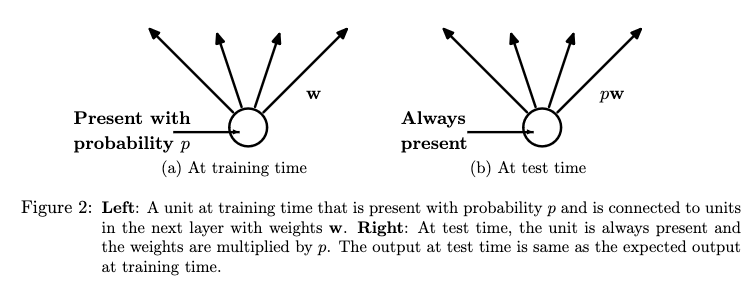

Look how Dropout changes the expected value of an activation compared to the original input, and how the "scaling" trick restores the expected value that subsequent layers of the model will be used to receiving during training.

In [9]:
# while making predictions on validation dataset or in production
x = torch.rand((1_000_000,))
p = 0.7
bern = torch.distributions.bernoulli.Bernoulli(p).sample(x.shape)

eval_output = x * p
train_output = x * bern

x.mean(), eval_output.mean(), train_output.mean()

(tensor(0.50), tensor(0.35), tensor(0.35))

We can see that scaling the output at evaluation time allows the expected value of each activation to remain at the same magnitude. It's worth noting, however, that this does _not_ apply to variance, and variance of activation values are a very important topic, and Dropout makes that more difficult to manage. We won't address that here.

Let's train the model and see how well it works!

In [10]:
lin_dropout = nn.Sequential(
    LinReluDropout(0.9, (784, 8192)),
    LinReluDropout(0.8, (8192, 8192)),
    LinReluDropout(0.8, (8192, 8192)),
    nn.Linear(8192, 10) # not using dropout on the final layer
)

epochs=10
train_model(epochs, lin_dropout)

epoch 0:	test/acc=0.691	test/loss=2.044	train/acc=0.679	train/loss=2.0126254558563232
epoch 1:	test/acc=0.762	test/loss=0.904	train/acc=0.772	train/loss=0.8366471529006958
epoch 2:	test/acc=0.838	test/loss=0.578	train/acc=0.786	train/loss=0.5576978325843811
epoch 3:	test/acc=0.864	test/loss=0.537	train/acc=0.816	train/loss=0.44125449657440186
epoch 4:	test/acc=0.908	test/loss=0.380	train/acc=0.891	train/loss=0.33094996213912964
epoch 5:	test/acc=0.911	test/loss=0.327	train/acc=0.906	train/loss=0.31101763248443604
epoch 6:	test/acc=0.922	test/loss=0.292	train/acc=0.920	train/loss=0.278736412525177
epoch 7:	test/acc=0.922	test/loss=0.270	train/acc=0.927	train/loss=0.27532845735549927
epoch 8:	test/acc=0.931	test/loss=0.270	train/acc=0.920	train/loss=0.24898649752140045
epoch 9:	test/acc=0.928	test/loss=0.222	train/acc=0.936	train/loss=0.24538768827915192


In [11]:
lin_dropout = nn.Sequential(
    LinReluDropout(0.9, (784, 8192)),
    LinReluDropout(0.8, (8192, 8192)),
    LinReluDropout(0.8, (8192, 8192)),
    nn.Linear(8192, 10) # not using dropout on the final layer
)

epochs=10
train_model(epochs, lin_dropout)

epoch 0:	test/acc=0.655	test/loss=2.033	train/acc=0.609	train/loss=2.0046274662017822
epoch 1:	test/acc=0.812	test/loss=0.884	train/acc=0.785	train/loss=0.791739284992218
epoch 2:	test/acc=0.857	test/loss=0.540	train/acc=0.834	train/loss=0.5102406144142151
epoch 3:	test/acc=0.857	test/loss=0.509	train/acc=0.856	train/loss=0.4455821216106415
epoch 4:	test/acc=0.904	test/loss=0.403	train/acc=0.888	train/loss=0.3393307328224182
epoch 5:	test/acc=0.916	test/loss=0.321	train/acc=0.903	train/loss=0.3077983558177948
epoch 6:	test/acc=0.921	test/loss=0.312	train/acc=0.922	train/loss=0.28513863682746887
epoch 7:	test/acc=0.917	test/loss=0.289	train/acc=0.912	train/loss=0.28559666872024536
epoch 8:	test/acc=0.923	test/loss=0.300	train/acc=0.926	train/loss=0.26086339354515076
epoch 9:	test/acc=0.931	test/loss=0.260	train/acc=0.923	train/loss=0.2404402643442154


# Comparison to Fully-connected network without Dropout

How does Dropout compare to _not_ using dropout? Let's write a simple linear model, identical to the previous one except for not using dropout.

In [12]:
linmod = nn.Sequential(
    LinWithRelu(784, 8192),
    LinWithRelu(8192, 8192),
    LinWithRelu(8192, 8192),
    nn.Linear(8192, 10)
)

epochs=10
train_model(epochs, linmod)

epoch 0:	test/acc=0.829	test/loss=0.945	train/acc=0.798	train/loss=0.8940132856369019
epoch 1:	test/acc=0.885	test/loss=0.511	train/acc=0.858	train/loss=0.44120755791664124
epoch 2:	test/acc=0.908	test/loss=0.347	train/acc=0.907	train/loss=0.3311283588409424
epoch 3:	test/acc=0.900	test/loss=0.386	train/acc=0.903	train/loss=0.3372243046760559
epoch 4:	test/acc=0.926	test/loss=0.266	train/acc=0.922	train/loss=0.26230525970458984
epoch 5:	test/acc=0.931	test/loss=0.269	train/acc=0.922	train/loss=0.24377484619617462
epoch 6:	test/acc=0.936	test/loss=0.223	train/acc=0.931	train/loss=0.2235965132713318
epoch 7:	test/acc=0.942	test/loss=0.235	train/acc=0.929	train/loss=0.21045100688934326
epoch 8:	test/acc=0.945	test/loss=0.191	train/acc=0.949	train/loss=0.1966145634651184
epoch 9:	test/acc=0.947	test/loss=0.199	train/acc=0.947	train/loss=0.19025175273418427


# Disappointment, but with a lesson

Looks like _not_ using dropout actually worked better! To see why, it's helpful to realize what problem dropout is trying to solve.

Dropout adds regularization to a network and helps address network overparameterization and overfitting. It is about toxic and fragile co-adaptations between layers where a model can be so complex that "mistakes" in one layer can be "corrected" by another layer. It would be better to iron out the mistakes in the first place, though! By randomly dropping activations, dropout can run through forward passes where the "correction" of one layer has nothing to correct because the mistake got "dropped" or the "mistake" of the first layer has nothing later on to correct it, so the mistake must be unlearned from the get-go.

The original Dropout paper saw an improvement using dropout on the MNIST dataset, but they were also using fine-tuned hyperparameters and an extensive training budget to produce results that, at the time, were world-record breaking. For simpler ways of attacking MNIST, Dropout won't always help.

But what we've seen now is how to build Dropout, and we've learnt something about what makes it useful, albeit in a surprising way.

Stay tuned for Part II where we'll showcase Dropout in a more complex dataset that actually _needs_ it!